#### Assignment 2: Computer Vision 2

#### Imports

In [158]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from packaging import version
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
from tensorflow.keras.regularizers import l1, l2
from collections import Counter
from sklearn.manifold import TSNE
from keras.models import Model

#### EDA Functions

In [2]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)

    x = x[indices]
    y = y[indices]

    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)

    x = x[indices]
    y = y[indices]

    y = tf.keras.utils.to_categorical(y)

    return x, y

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

#### Research Functions

In [3]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

#### Model and Performance Functions

In [6]:
def compile_train_model(model, x_train, y_train, x_valid, y_valid, epochs=200):
  timestamp=int(time.time())

  # Compile
  model.compile(optimizer='rmsprop',
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
  start_time = time.time()
  history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=512,
    validation_data=(x_valid, y_valid),
    #verbose=0,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
        ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
        ]
  )
  end_time = time.time()
  second_elapsed = round(end_time - start_time)

  print(f'Finished model training in {second_elapsed}s')

  print('Model performance with training set')
  model.evaluate(x_train, y_train)

  print('Evaluating model performance with validation set')
  model.evaluate(x_valid, y_valid)

  return history, model

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

#### Import the CIFAR-10 Data Set

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

#### Pre-Processing

In [11]:
# Create validation set
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [12]:
# Rescale
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

#### Experiment 1 - Dense Neural Network, 2 Layers, No Regularaziation

In [13]:
model_one = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_one.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_one = model_one.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_one.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]                                                                                                       
                   )

model_one = tf.keras.models.load_model("model_one.h5")

pred_one = model_one.predict(x_test_norm)

pred_one = np.argmax(pred_one, axis=1)

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 0s 535us/step


#### Experiment 2 - Dense Neural Network, 3 Layers, No Regularization

In [14]:
model_two = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  Dense(units=512,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_two.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_two = model_two.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_two.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]                                                                                                       
                   )

model_two = tf.keras.models.load_model("model_two.h5")

pred_two = model_two.predict(x_test_norm)

pred_two = np.argmax(pred_two, axis=1)

313/313 [==============================] - 0s 661us/step


#### Experiment 3 - Convolutional Neural Network, 2 Convolutional & Max Pooling Layers, No Regularization

In [16]:
model_three = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_three.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_three = model_three.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_three.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]                                                                                                       
                   )

model_three = tf.keras.models.load_model("model_three.h5")

pred_three = model_three.predict(x_test_norm)

pred_three = np.argmax(pred_three, axis=1)

313/313 [==============================] - 1s 4ms/step


#### Experiment 4 - Convolutional Neural Network, 3 Convolutional & Max Pooling Layers, No Regularization

In [17]:
model_four = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_four.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_four = model_four.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_four.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]                                                                                                       
                   )

model_four = tf.keras.models.load_model("model_four.h5")

pred_four = model_four.predict(x_test_norm)

pred_four = np.argmax(pred_four, axis=1)

313/313 [==============================] - 2s 5ms/step


#### Experiment 5

In [18]:
model_five = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_five.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_five = model_five.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_five.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]                                                                                                       
                   )

model_five = tf.keras.models.load_model("model_five.h5")

pred_five = model_five.predict(x_test_norm)

pred_five = np.argmax(pred_five, axis=1)

313/313 [==============================] - 0s 543us/step


#### Experiment 6

In [19]:
model_six = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=512,activation=tf.nn.relu),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_six.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_six = model_six.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_six.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]                                                                                                       
                   )

model_six = tf.keras.models.load_model("model_six.h5")

pred_six = model_six.predict(x_test_norm)

pred_six = np.argmax(pred_six, axis=1)

313/313 [==============================] - 0s 807us/step


#### Experiment 7

In [20]:
model_seven = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)        
])

model_seven.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_seven = model_seven.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_seven.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]                                                                                                       
                   )

model_seven = tf.keras.models.load_model("model_seven.h5")

pred_seven = model_seven.predict(x_test_norm)

pred_seven = np.argmax(pred_seven, axis=1)

313/313 [==============================] - 1s 4ms/step


#### Experiment 8

In [21]:
model_eight = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)   
])

model_eight.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_eight = model_eight.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_eight.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]                                                                                                       
                   )

model_eight = tf.keras.models.load_model("model_eight.h5")

pred_eight = model_eight.predict(x_test_norm)

pred_eight = np.argmax(pred_eight, axis=1)

313/313 [==============================] - 2s 5ms/step


#### Experiment 9

In [87]:
model_nine = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)    
])

model_nine.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_nine = model_nine.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_nine.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]                                                                                                       
                   )

model_nine = tf.keras.models.load_model("model_nine.h5")

pred_nine = model_nine.predict(x_test_norm)

pred_nine = np.argmax(pred_nine, axis=1)

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 4s 13ms/step


#### Experiment 10

In [104]:
model_ten = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=256,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)     
])

model_ten.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

training_ten = model_ten.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=0
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("model_ten.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]                                                                                                       
                   )

model_ten = tf.keras.models.load_model("model_ten.h5")

pred_ten = model_ten.predict(x_test_norm)

pred_ten = np.argmax(pred_ten, axis=1)

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 2s 5ms/step


#### Results

In [105]:
def create_results_dataframe(model_name,training_history,y_true,y_pred):
    training_history_df = pd.DataFrame(training_history.history)
    best_model = training_history_df.iloc[-1:,]
    best_model = best_model.reset_index().rename(columns={'index':'epoch','loss':'training_loss','accuracy':'training_accuracy'})

    best_model['test_accuracy'] = accuracy_score(y_true,y_pred)
    best_model['precision_micro'] = precision_score(y_true,y_pred,average='micro')
    best_model['recall_micro'] = recall_score(y_true,y_pred,average='micro')
    best_model['f1_score_micro'] = f1_score(y_true,y_pred,average='micro')

    best_model['model_name'] = model_name

    results = best_model.iloc[:,[-1,0,1,2,3,4,5,6,7,8]]

    return(results)

In [107]:
experiment_results = pd.DataFrame(columns=['model','epoch','accuracy','loss','precision_micro','recall_micro','f1_score_micro'])

experiment_1_results = create_results_dataframe('model_one',training_one,y_test,pred_one)
experiment_2_results = create_results_dataframe('model_two',training_two,y_test,pred_two)
experiment_3_results = create_results_dataframe('model_three',training_three,y_test,pred_three)
experiment_4_results = create_results_dataframe('model_four',training_four,y_test,pred_four)
experiment_5_results = create_results_dataframe('model_five',training_five,y_test,pred_five)
experiment_6_results = create_results_dataframe('model_six',training_six,y_test,pred_six)
experiment_7_results = create_results_dataframe('model_seven',training_seven,y_test,pred_seven)
experiment_8_results = create_results_dataframe('model_eight',training_eight,y_test,pred_eight)
experiment_9_results = create_results_dataframe('model_nine',training_nine,y_test,pred_nine)
experiment_10_results = create_results_dataframe('model_ten',training_ten,y_test,pred_ten)

experiment_results = pd.concat([
    experiment_1_results,
    experiment_2_results,
    experiment_3_results,
    experiment_4_results,
    experiment_5_results,
    experiment_6_results,
    experiment_7_results,
    experiment_8_results,
    experiment_9_results,
    experiment_10_results
    ]).reset_index(drop=True)
    
experiment_results['training_time'] = [
    '0:51',
    '0:54',
    '3:43',
    '4:56',
    '0:35',
    '0:46',
    '7:45',
    '11:27',
    '72:02',
    '9:41'
]

experiment_results

,model_name,epoch,training_loss,training_accuracy,val_loss,val_accuracy,test_accuracy,precision_micro,recall_micro,f1_score_micro,training_time
0,model_one,29,1.355056,0.517044,1.527048,0.4642,0.4774,0.4774,0.4774,0.4774,0:51
1,model_two,24,1.194971,0.569889,1.593661,0.4588,0.4955,0.4955,0.4955,0.4955,0:54
2,model_three,13,0.120724,0.958778,1.482237,0.7030,0.7087,0.7087,0.7087,0.7087,3:43
3,model_four,15,0.132124,0.952000,1.400252,0.7228,0.7293,0.7293,0.7293,0.7293,4:56
4,model_five,19,1.649362,0.415044,1.608292,0.4324,0.4374,0.4374,0.4374,0.4374,0:35
5,model_six,16,1.507852,0.462578,1.502971,0.4496,0.4706,0.4706,0.4706,0.4706,0:46
6,model_seven,27,0.437040,0.842978,0.696129,0.7646,0.7643,0.7643,0.7643,0.7643,7:45
7,model_eight,36,0.505810,0.822044,0.575077,0.8020,0.7947,0.7947,0.7947,0.7947,11:27
8,model_nine,60,0.216936,0.923044,0.592995,0.8210,0.8193,0.8193,0.8193,0.8193,72:02
9,model_ten,28,1.482897,0.603111,1.432577,0.6080,0.6625,0.6625,0.6625,0.6625,9:41


In [108]:
def plot_confusion_matrices(y_preds, y_true):
    num_sets = len(y_preds)
    cols = min(4, num_sets)
    rows = (num_sets + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), squeeze=False)

    for i, (y_pred, ax) in enumerate(zip(y_preds, axs.flat)):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=np.unique(y_true), yticklabels=np.unique(y_true), ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(f"Model {i+1}")

    # Remove any empty subplots in the bottom row
    for i in range(num_sets, rows * cols):
        axs.flat[i].axis("off")

    plt.tight_layout()
    plt.show()

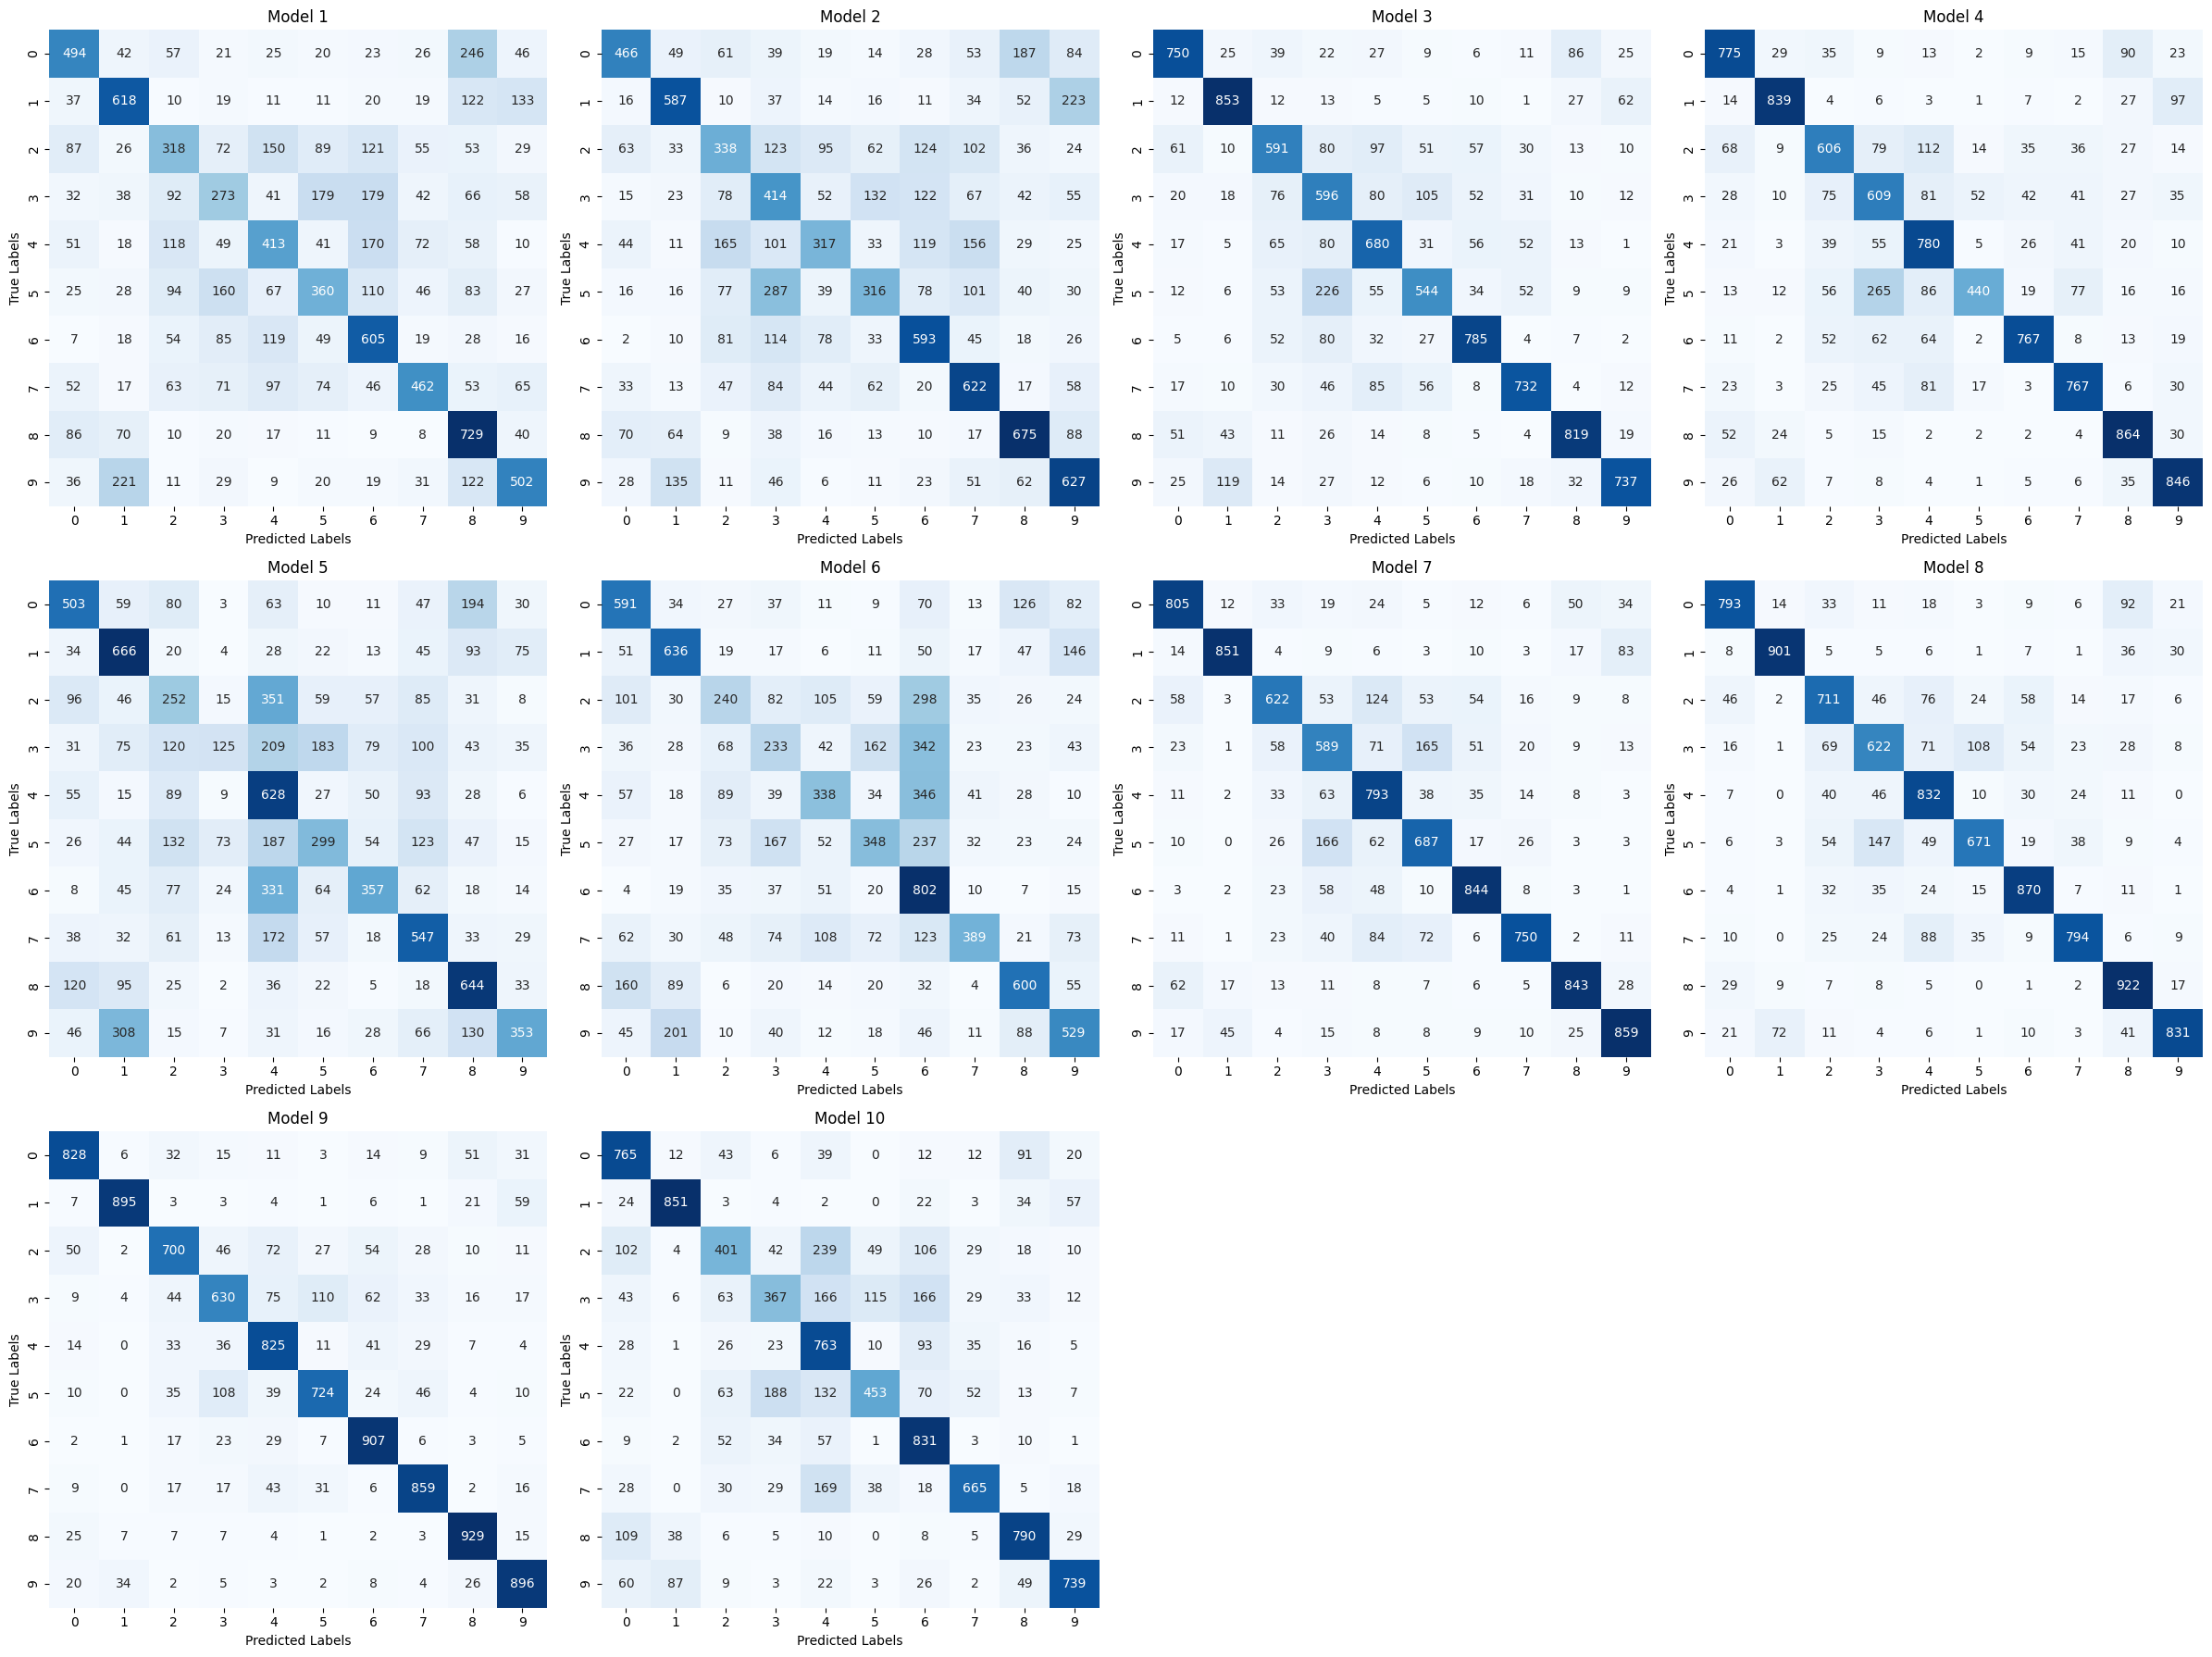

In [109]:
plot_confusion_matrices(
    [pred_one,
    pred_two,
    pred_three,
    pred_four,
    pred_five,
    pred_six,
    pred_seven,
    pred_eight,
    pred_nine,
    pred_ten]
    ,y_test
)

In [110]:
def plot_training_history(history_list,n):
    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    # fig.suptitle('Training and Validation Accuracy and Loss', fontsize=16)

    for i, history in enumerate(history_list):
        row_idx = i // 4
        col_idx = i % 4

        training_accuracy = history.history['accuracy']
        validation_accuracy = history.history['val_accuracy']
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']

        # Plot training accuracy against validation accuracy
        axes[row_idx, col_idx].plot(training_accuracy, label='Training Accuracy')
        axes[row_idx, col_idx].plot(validation_accuracy, label='Validation Accuracy')
        axes[row_idx, col_idx].set_xlabel('Epochs')
        axes[row_idx, col_idx].set_ylabel('Accuracy')
        axes[row_idx, col_idx].set_title(f'Model {n + i + 1} Accuracy')
        axes[row_idx, col_idx].legend()

        # Plot training loss against validation loss
        axes[row_idx + 1, col_idx].plot(training_loss, label='Training Loss')
        axes[row_idx + 1, col_idx].plot(validation_loss, label='Validation Loss')
        axes[row_idx + 1, col_idx].set_xlabel('Epochs')
        axes[row_idx + 1, col_idx].set_ylabel('Loss')
        axes[row_idx + 1, col_idx].set_title(f'Model {n + i + 1} Loss')
        axes[row_idx + 1, col_idx].legend()

    # Adjust layout and display the plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


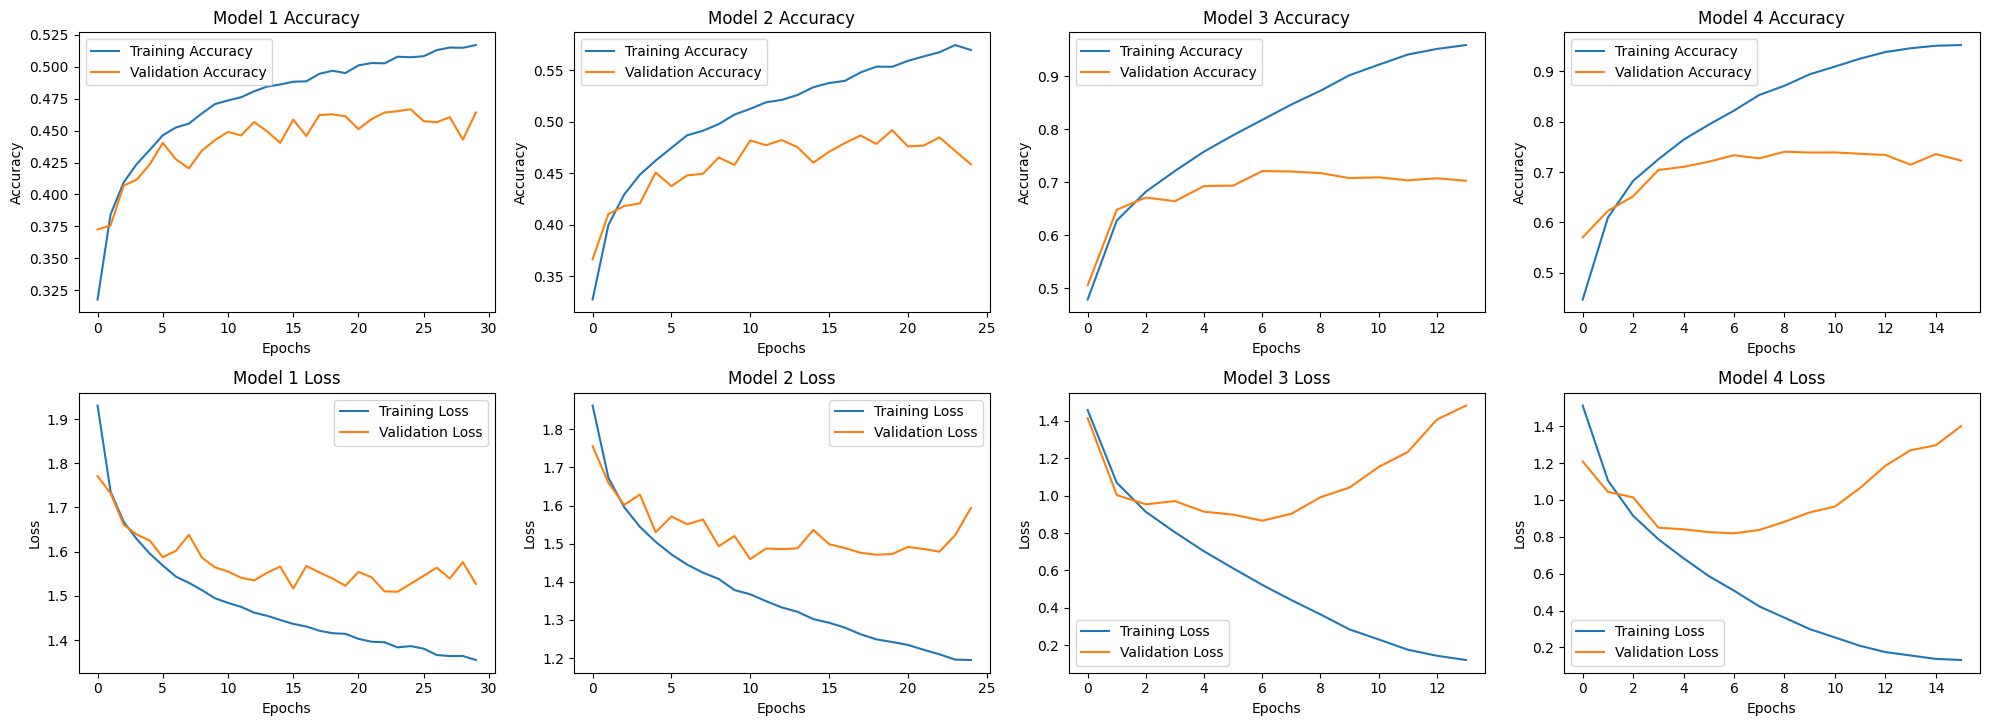

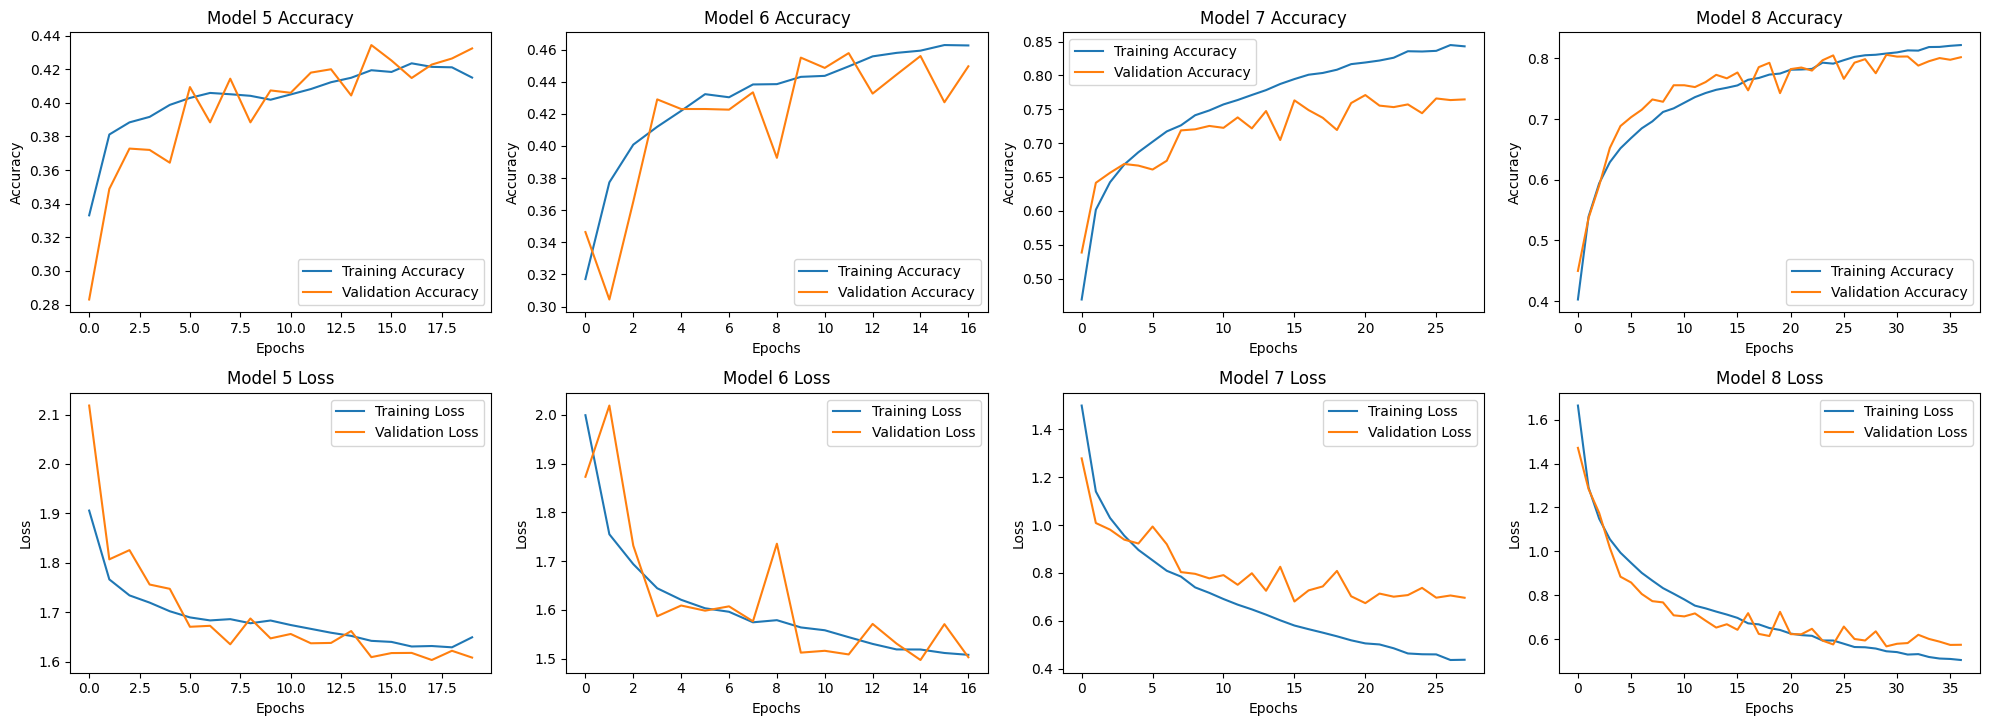

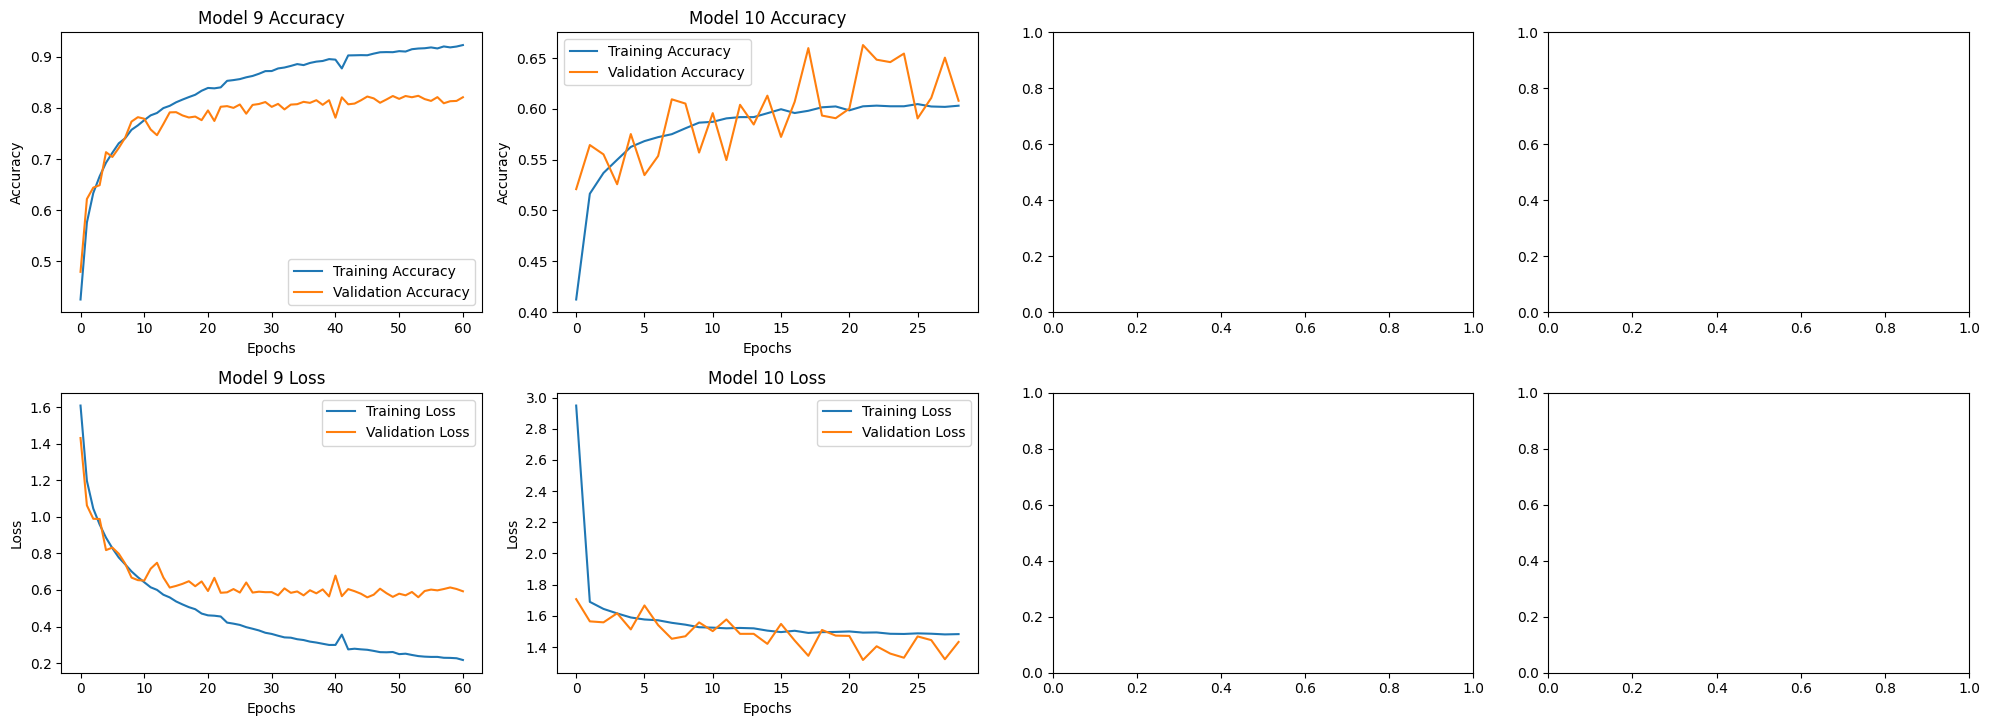

In [111]:
plot_training_history([training_one,training_two,training_three,training_four],0)
plot_training_history([training_five,training_six,training_seven,training_eight],4)
plot_training_history([training_nine,training_ten],8)

63/63 [==============================] - 1s 16ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.261151
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.605225
[t-SNE] KL divergence after 300 iterations: 1.664272


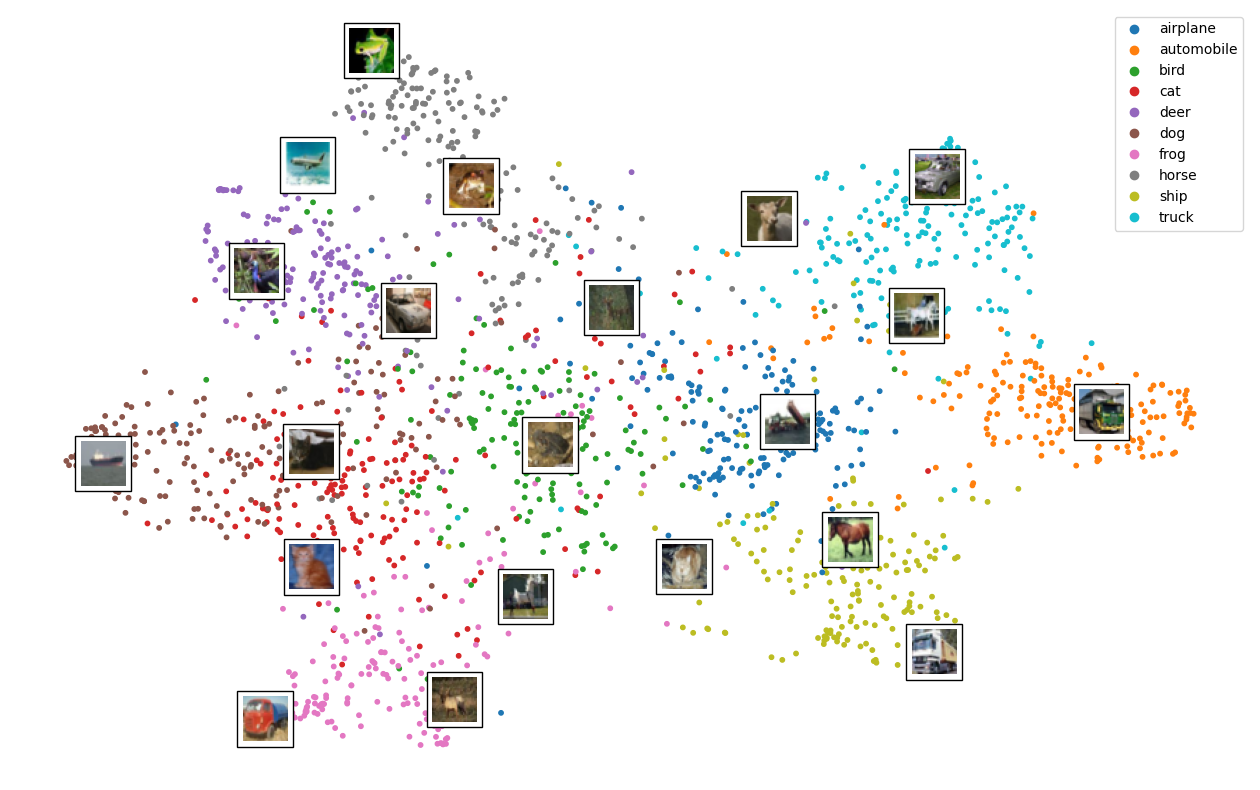

In [162]:
model = model_nine

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:2000])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

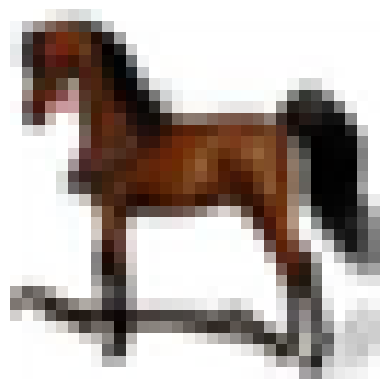

1/1 [==============================] - 0s 59ms/step


14

['conv2d_15',
 'max_pooling2d_15',
 'dropout_10',
 'conv2d_16',
 'max_pooling2d_16',
 'dropout_11',
 'conv2d_17',
 'max_pooling2d_17',
 'dropout_12',
 'flatten_10',
 'dense_22',
 'batch_normalization_5',
 'dropout_13',
 'dense_23']

/var/folders/hb/_tr1b6d918vdtcwmymd4p0v80000gn/T/ipykernel_1373/2729935935.py:63: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
/var/folders/hb/_tr1b6d918vdtcwmymd4p0v80000gn/T/ipykernel_1373/2729935935.py:66: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


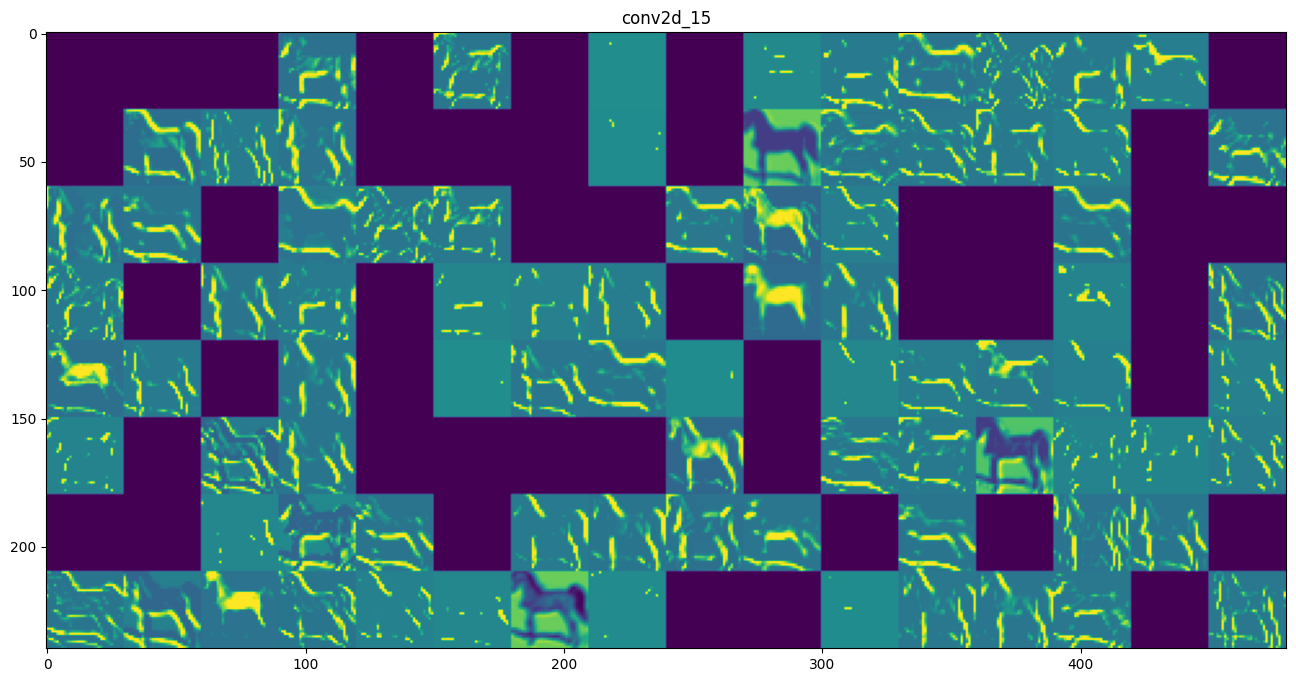

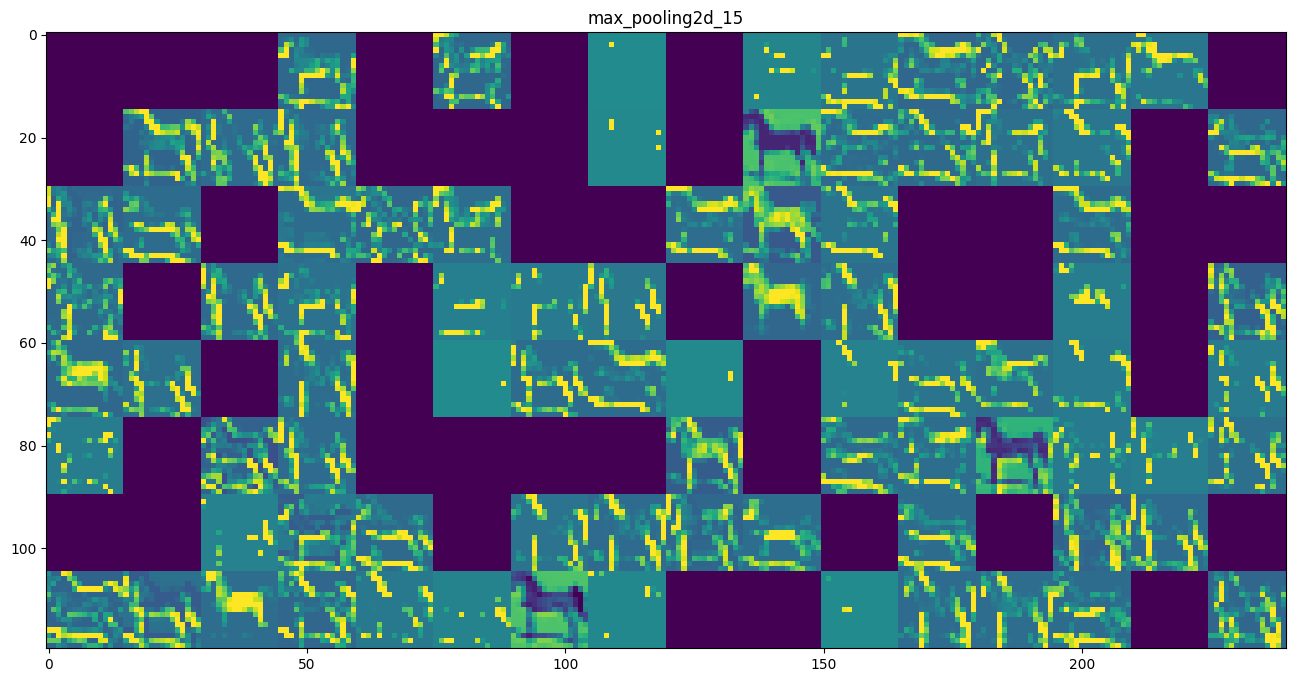

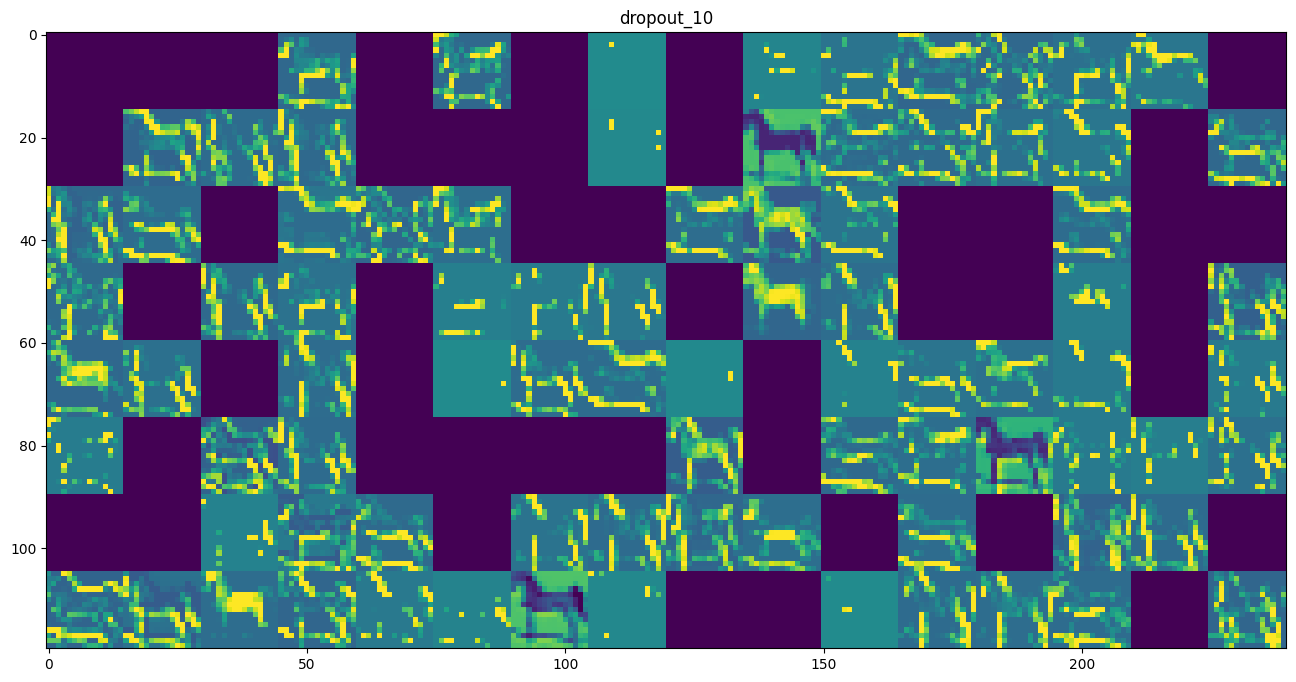

In [163]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)
display(len(activations))

layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

display(layer_names)

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show();